In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#do not use these variable names: f0, f1, f2, g1, g2, g3, g5, f_new1, f_new2, f_new3

from iHMM_GP.step1_utils import *
from iHMM_GP.data_setup import *

/Users/sunrit/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1058: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


# Demo 1

Compare only forward pass vs with refinement. 2 different settings


## Setting 1:

$R^2\to R^2$ vector fields, $K=9, T=100, n=50, \sigma^2=1$.

No held out is done. Also, no spatial censoring is done.

Get the following:

0. number of components
1. loglikelihood on train and test
2. label estimation accuracy on train and test
3. time

In [2]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def demo1_2d(T=100, n=50, sigma2=0.8):
    
    T_test = 50

    # create data
    data, s = sim_new_data2(f_true, Pi_true, T=T+T_test, n=n, sigma2=sigma2)

    # get training data - for t in tau, hold out q% of the data
    data_train = []

    for t in range(T):
        X, Y = data[t]
        data_train.append((X, Y))

    # test 3 - new sequence state prediction
    data_test3 = data[T:]

    # state labels:
    s_train_true = s[0:T]
    s_test_true = s[T:]
    
    # setup hyperparameters
    iHMM_params = (3, 3, 3)

    x, y = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
    Z = np.array([[x[i, j], y[i, j]] for i in range(10) for j in range(10)])

    # fit GPs
    import time
    time2 = time.time()
    marginal_lls, sigma2, all_kernels = get_all_GPs(data_train)
    time2 = time.time() - time2
    
    # only forward pass
    
    from sklearn.metrics import rand_score, adjusted_mutual_info_score, v_measure_score # (rand, NMI, vscore)
    time0 = time.time()
    s1, o1, models1, N1, M1 = forward_pass(data_train, iHMM_params, marginal_lls, all_kernels, sigma2, Z)
    logliks_train = get_likelihoods(data_train, models1, sigma2); logliks_train = np.array(logliks_train)
    K_opt = len(np.unique(s1))
    Pi_est, _ = get_nm(s1, np.zeros(T)); row_sums = Pi_est.sum(axis=1)
    row_sums = np.clip(row_sums, 1, 1e5)
    Pi_hat = Pi_est / row_sums[:, np.newaxis]
    for j in range(K_opt):
        if row_sums[j] == 0:
            Pi_hat[j] = np.ones(K_opt) /  K_opt
            
    s_final_train = s1
    final_models = models1
    
    logliks_train = get_likelihoods(data_train, final_models, sigma2); logliks_train = np.array(logliks_train) #
    time0 = time.time() - time0
    
    logliks_test = get_likelihoods(data_test3, final_models, sigma2); logliks_test = np.array(logliks_test)
    s_final_test = viterbi(None, None, Pi_hat, logliks_test)

    hmm_loglik_train = compute_likelihood_HMM(Pi_hat, logliks_train)
    hmm_loglik_test = compute_likelihood_HMM(Pi_hat, logliks_test)

    train_label_acc = (rand_score(s_train_true, s_final_train), adjusted_mutual_info_score(s_train_true, s_final_train), v_measure_score(s_train_true, s_final_train))
    test_label_acc = (rand_score(s_test_true, s_final_test), adjusted_mutual_info_score(s_test_true, s_final_test), v_measure_score(s_test_true, s_final_test))

    forward_result = {'K': K_opt,
                     'hmm_loglik_train': hmm_loglik_train,
                     'hmm_loglik_test': hmm_loglik_test,
                     'train_label_accuracy': train_label_acc,
                     'test_label_accuracy': test_label_acc,
                     'time': time0 + time2}

    time1 = time.time()
    s2, o2, models2, N2, M2 = refinement(s1, o1, N1, M1, models1, iHMM_params, sigma2, marginal_lls, data_train, min_cluster_size=2, verbose=False)
    logliks_train = get_likelihoods(data_train, models2, sigma2); logliks_train = np.array(logliks_train)
    Pi_est, _ = get_nm(s2, np.zeros(T)); row_sums = Pi_est.sum(axis=1)
    Pi_hat = Pi_est / row_sums[:, np.newaxis]
    s_final_train = viterbi(None, None, Pi_hat, logliks_train)

    # check if any cluster has 0 time points, can remove it
    s_final_train = rename_s(s_final_train)[1]
    K_opt = len(np.unique(s_final_train))
    time1 = time.time() - time1

    final_models = get_final_results(data_train, s_final_train, sigma2, Z, n_jobs=-1, N_max=1000) #new 2 lines
    logliks_train = get_likelihoods(data_train, final_models, sigma2); logliks_train = np.array(logliks_train) #
    Pi_est, _ = get_nm(s_final_train, np.zeros(T)); row_sums = Pi_est.sum(axis=1)
    Pi_hat = Pi_est / row_sums[:, np.newaxis]
    
    logliks_test = get_likelihoods(data_test3, final_models, sigma2); logliks_test = np.array(logliks_test)
    s_final_test = viterbi(None, None, Pi_hat, logliks_test)

    hmm_loglik_train = compute_likelihood_HMM(Pi_hat, logliks_train)
    hmm_loglik_test = compute_likelihood_HMM(Pi_hat, logliks_test)


    train_label_acc = (rand_score(s_train_true, s_final_train), adjusted_mutual_info_score(s_train_true, s_final_train), v_measure_score(s_train_true, s_final_train))
    test_label_acc = (rand_score(s_test_true, s_final_test), adjusted_mutual_info_score(s_test_true, s_final_test), v_measure_score(s_test_true, s_final_test))

    refined_result = {'K': K_opt,
                     'hmm_loglik_train': hmm_loglik_train,
                     'hmm_loglik_test': hmm_loglik_test,
                     'train_label_accuracy': train_label_acc,
                     'test_label_accuracy': test_label_acc,
                     'time': time1 + time0 + time2}
    
    return (forward_result, refined_result)

In [7]:
import time
import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)

time_start = time.time()
results = demo1_2d(T=100, n=50, sigma2=1)
time_end = time.time()
print('total time taken:', np.round(time_end - time_start, 2))

total time taken: 59.04


In [8]:
results # run on local machine

({'K': 23,
  'hmm_loglik_train': -14123.444808920882,
  'hmm_loglik_test': -7446.305670246069,
  'train_label_accuracy': (0.9557575757575758,
   0.800767515094084,
   0.8622879125452052),
  'test_label_accuracy': (0.9804081632653061,
   0.9151281092447017,
   0.9494254488754172),
  'time': 30.497332096099854},
 {'K': 9,
  'hmm_loglik_train': -14041.288394095422,
  'hmm_loglik_test': -7289.28373413006,
  'train_label_accuracy': (0.9854545454545455,
   0.9582888841920884,
   0.9657784089291803),
  'test_label_accuracy': (1.0, 1.0, 1.0),
  'time': 43.53420400619507})

In [10]:
# run on cluster with 20 cores
import pickle
from tqdm import tqdm
results = []

for rep in range(30):
    print('working rep ', rep)
    res = demo1_2d(T=100, n=50, sigma2=1)
    results.append(res)
    
pickle.dump(results, open( "new_simulation_results/demo1.p", "wb" ) )

working rep  0
working rep  1
working rep  2
working rep  3
working rep  4
working rep  5
working rep  6
working rep  7
working rep  8
working rep  9
working rep  10
working rep  11
working rep  12
working rep  13
working rep  14
working rep  15
working rep  16
working rep  17
working rep  18
working rep  19
working rep  20
working rep  21
working rep  22
working rep  23
working rep  24
working rep  25
working rep  26
working rep  27
working rep  28
working rep  29


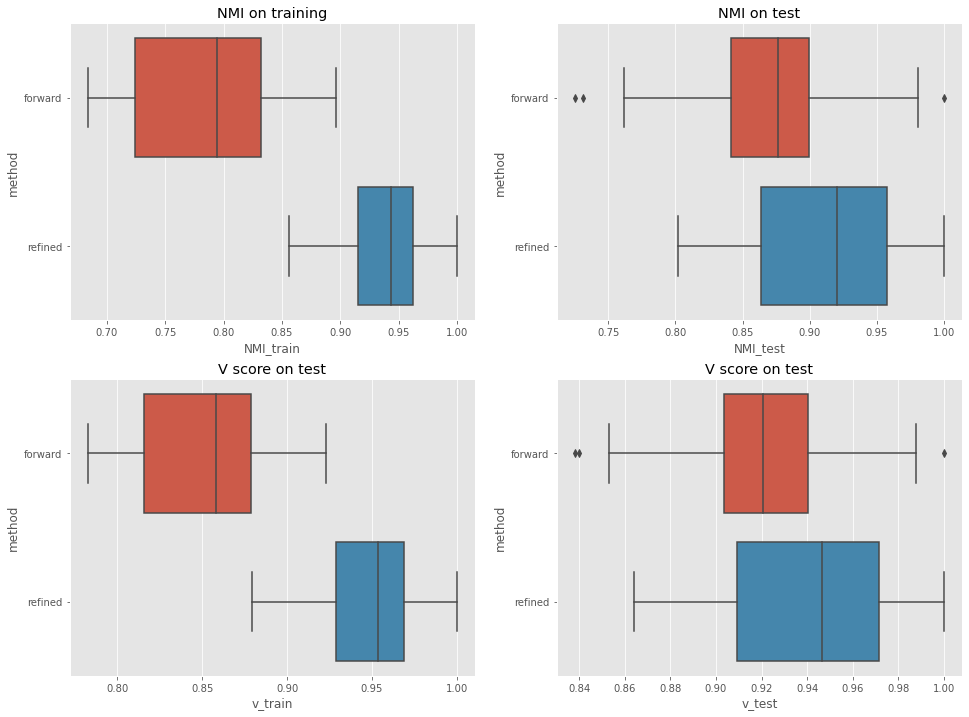

In [12]:
import pandas as pd
import seaborn as sns

rep = 30
NMI_train_forward = [results[i][0]['train_label_accuracy'][1] for i in range(rep)]
NMI_test_forward = [results[i][0]['test_label_accuracy'][1] for i in range(rep)]

NMI_train_ref = [results[i][1]['train_label_accuracy'][1] for i in range(rep)]
NMI_test_ref = [results[i][1]['test_label_accuracy'][1] for i in range(rep)]

v_train_forward = [results[i][0]['train_label_accuracy'][2] for i in range(rep)]
v_test_forward = [results[i][0]['test_label_accuracy'][2] for i in range(rep)]

v_train_ref = [results[i][1]['train_label_accuracy'][2] for i in range(rep)]
v_test_ref = [results[i][1]['test_label_accuracy'][2] for i in range(rep)]



df = pd.DataFrame({'NMI_train': np.append(NMI_train_forward, NMI_train_ref),
                   'NMI_test': np.append(NMI_test_forward, NMI_test_ref),
                   'v_train': np.append(v_train_forward, v_train_ref),
                   'v_test': np.append(v_test_forward, v_test_ref),
                  'method': ['forward']*rep + ['refined']*rep})

fig = plt.figure(figsize=(16, 12))

plt.subplot(2,2,1).set_title('NMI on training')
sns.boxplot( x=df["NMI_train"], y=df["method"])

plt.subplot(2,2,2).set_title('NMI on test')
sns.boxplot( x=df["NMI_test"], y=df["method"])

plt.subplot(2,2,3).set_title('V score on test')
sns.boxplot( x=df["v_train"], y=df["method"])

plt.subplot(2,2,4).set_title('V score on test')
sns.boxplot( x=df["v_test"], y=df["method"])

plt.show()

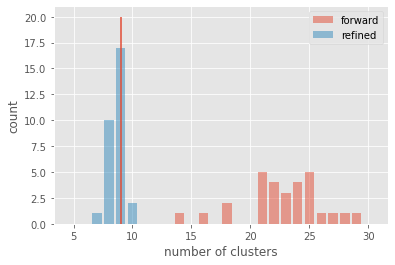

In [15]:
K1 = [results[i][0]['K'] for i in range(30)]
K2 = [results[i][1]['K'] for i in range(30)]

K1 = np.array(K1)
K2 = np.array(K2)

values = np.arange(5, np.max(K1))
K1_counts = np.array([np.sum(K1==k) for k in values])
K2_counts = np.array([np.sum(K2==k) for k in values])

plt.bar(values, K1_counts, alpha=0.5, label='forward')
plt.bar(values, K2_counts, alpha=0.5, label='refined')
plt.vlines(9, ymin=0, ymax=20)
plt.legend(loc='upper right')
plt.xlabel('number of clusters')
plt.ylabel('count')
plt.show()

In [29]:
np.min(NMI_train_forward)

-0.0006865661190992325